# Exchange Rate Time Series Analysis

Project by:

30 - Jyothi Mudalu (UID: 2309039)

34 -  Sanika Shinde (UID: 2309043)


### Data
Data is gathered from https://fred.stlouisfed.org using the FRED API.
The exchange rate in the collected data has a frequency of `Month` and is the average of the daily exchange rates.

The FRED API provides the exchange rate as a ratio of the two currencies based on the value of them compared to the other.


***India has USD/Currency ratio.***


### Data Attributes

Date - date in ISO format

Value - currency rate


**4 MODELS: **

ARIMA

SARIMA

LSTM

EXPONENTIAL SMOOTHING

In [ ]:
!pip install fredapi

In [ ]:
# import the necessary libraries
import pandas as pd
from fredapi import Fred
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Extraction and Storing

In [ ]:
# Creating the Fred object with the API key
fred = Fred(api_key='70a5960bdec357f09a4d4922e4c749d7')

In [ ]:
# The USD/INR ratio is obtained and stored to the local
ind_monthly = fred.get_series(series_id = 'EXINUS')
ind_monthly.to_csv('indm.csv')
ind_monthly

,0
1973-01-01,8.0041
1973-02-01,7.7538
1973-03-01,7.5465
1973-04-01,7.5462
1973-05-01,7.4927
...,...
2024-04-01,83.3968
2024-05-01,83.3873
2024-06-01,83.4600
2024-07-01,83.5895


## Data Cleaning and Pre-Processing

In [ ]:
ind_df = pd.DataFrame({'Exchange_rate': ind_monthly})
ind_df

,Exchange_rate
1973-01-01,8.0041
1973-02-01,7.7538
1973-03-01,7.5465
1973-04-01,7.5462
1973-05-01,7.4927
...,...
2024-04-01,83.3968
2024-05-01,83.3873
2024-06-01,83.4600
2024-07-01,83.5895


In [ ]:
ind_df = ind_df.loc['2014-01-01':'2024-06-01']
ind_df

,Exchange_rate
2014-01-01,62.1057
2014-02-01,62.1642
2014-03-01,60.9476
2014-04-01,60.3464
2014-05-01,59.2843
...,...
2024-02-01,82.9485
2024-03-01,83.0214
2024-04-01,83.3968
2024-05-01,83.3873


In [ ]:
ind_df.index = pd.to_datetime(ind_df.index)

In [ ]:
# Setting the period of the data to be the Month Start
ind_df = ind_df.asfreq('MS')

### 2) Missing value treatment


In [ ]:
ind_df.isnull().sum()

,0
Exchange_rate,0


There are no missing values in the data set.

 Initial Visualization of the Exchange Rates

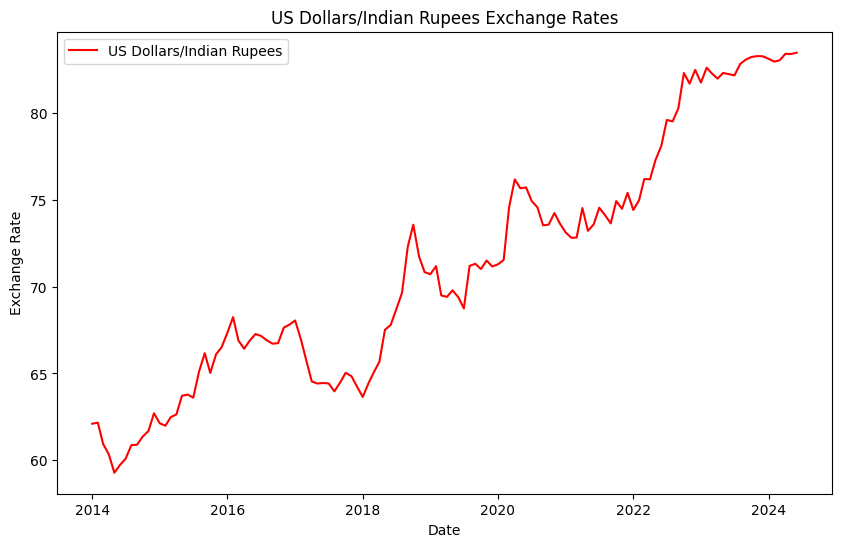

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ind_df['Exchange_rate'], color='red', label = "US Dollars/Indian Rupees")
plt.title('US Dollars/Indian Rupees Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### 5) Testing for Stationarity

Mean and Standard Deviation

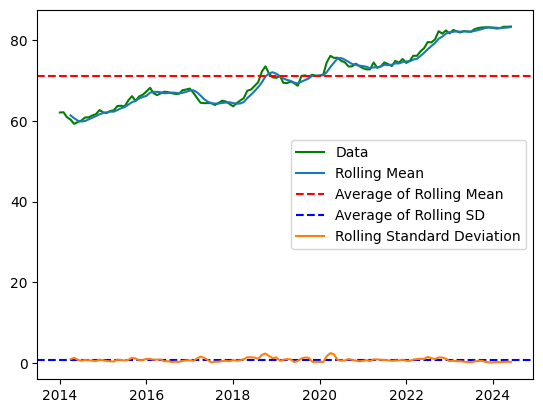

In [ ]:
window_size = 4 # Quarterly window
rolling_mean = ind_df['Exchange_rate'].rolling(window=window_size).mean()
rolling_std = ind_df['Exchange_rate'].rolling(window=window_size).std()
plt.plot(ind_df['Exchange_rate'], color = 'g', label = 'Data')
plt.plot(rolling_mean, label = "Rolling Mean")
plt.axhline(y= np.mean(rolling_mean), color='r', linestyle='--', label = "Average of Rolling Mean")
plt.axhline(y= np.mean(rolling_std), color='b', linestyle='--', label = "Average of Rolling SD")
plt.plot(rolling_std, label = "Rolling Standard Deviation")
plt.legend();

From the above figures, we can conclude the following —

The mean of the time-series data is not constant
There seems to be some trend in the data.
We can decompose the data into trend, seasonality, and residuals.

#### b)  Augmented Dickey-Fuller Test

`Null Hypothesis`: The dataset is non-stationary.</b>

`Alternate Hypothesis`: The dataset is stationary.

<i>The Null hypothesis is rejected if the p-value is less than 0.05</i>

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Performing the Augmented Dickey-Fuller (ADF) test
result = adfuller(ind_df['Exchange_rate'])

adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)



ADF Statistic: -0.15089777932089868
p-value: 0.9441269689219846


#### Interpretation

- The p-value is grater than `0.05`, therefore, the Null Hypothesis is accepted, i.e., the data is `Non-stationary`!

Both the above tests say that the dataset is non-stationary!

Therefore, it has to be converted to stationary before applying any time-series analysis

### 6) Dealing with Non-Stationarity

#### a) Decomposing the Time Series

We used the `seasonal_decompose()` function to extract the trend, seasonality, and residuals of the datasets. This helped us better visualize the seasonal trends.

In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

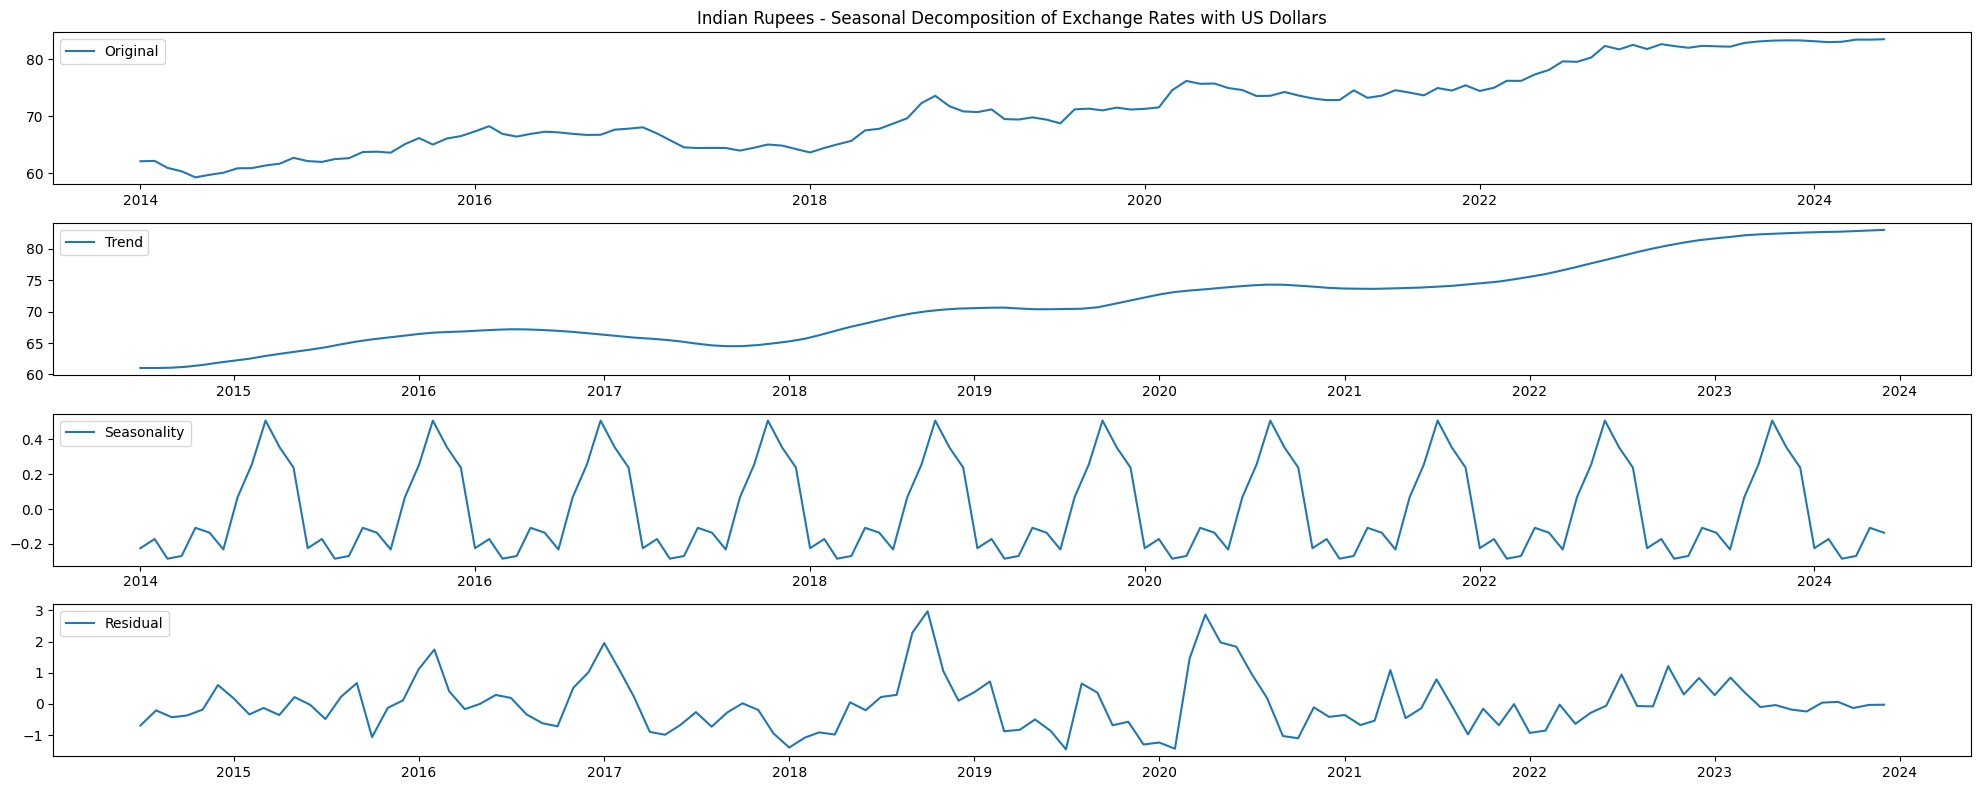

In [ ]:
ind_decomposition = seasonal_decompose(ind_df['Exchange_rate'], model='additive', period = 12)
ind_trend =ind_decomposition.trend
ind_seasonal = ind_decomposition.seasonal
ind_residual = ind_decomposition.resid
plt.figure(figsize = (20,8))
plt.subplot(411)
plt.title("Indian Rupees - Seasonal Decomposition of Exchange Rates with US Dollars")
plt.plot(ind_df, label = "Original")
plt.legend(loc = "upper left")
plt.subplot(412)
plt.plot(ind_trend, label = "Trend")
plt.legend(loc = "upper left")
plt.subplot(413)
plt.plot(ind_seasonal, label = "Seasonality")
plt.legend(loc = "upper left")
plt.subplot(414)
plt.plot(ind_residual, label = "Residual")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

#### Notes

- We implemented an annual seasonality (period = 12) for the decomposition as the exchange rates tend to be follow a pattern on a monthly basis forming a cyclic pattern annually.

#### b) Differencing the exchange rates

We considered differencing for converting the datasets into stationary because the residuals obtained from the seasonal decomposition is not purely white noise and seems to have trend which might affect the ARIMA model.

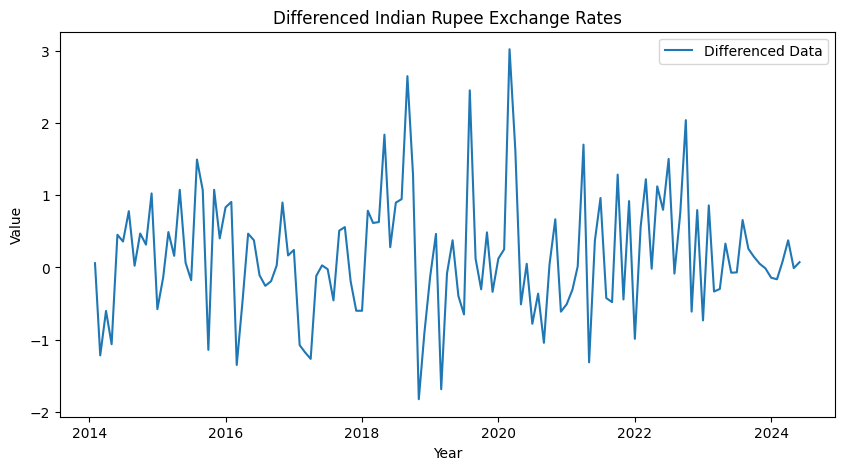

In [ ]:
ind_df['Differenced_Data'] = ind_df['Exchange_rate'].diff()
ind_df = ind_df.dropna()
# Plot the differenced time series data
plt.figure(figsize=(10, 5))
plt.title("Differenced Indian Rupee Exchange Rates")
plt.plot(ind_df.index, ind_df['Differenced_Data'], label='Differenced Data')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

The differenced data exhibits less traces of trends and is considered for the forecasting

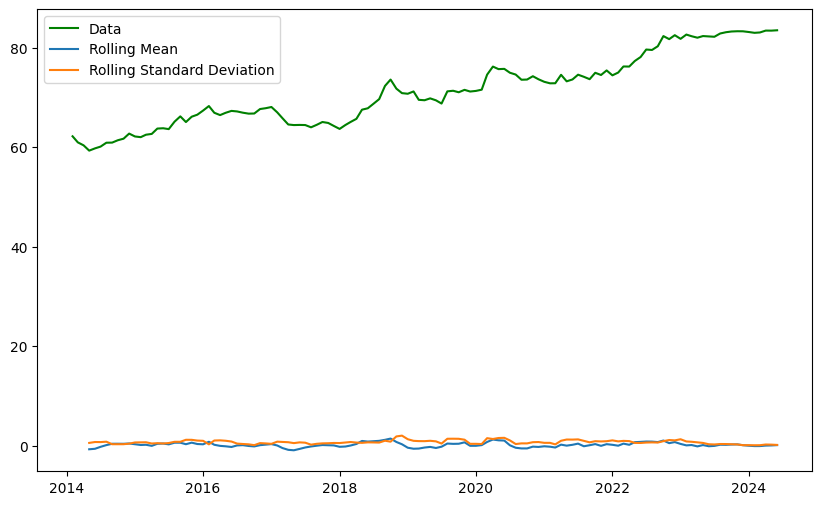

In [ ]:
plt.figure(figsize=(10, 6))
window_size = 4 # Quarterly window
rolling_mean = ind_df['Differenced_Data'].rolling(window=window_size).mean()
rolling_std = ind_df['Differenced_Data'].rolling(window=window_size).std()
plt.plot(ind_df['Exchange_rate'], color = 'g', label = 'Data')
plt.plot(rolling_mean, label = "Rolling Mean")
plt.plot(rolling_std, label = "Rolling Standard Deviation")
plt.legend();

Mean: The rolling mean shows a general upward trend, suggesting that the mean of the data is not constant. This is indicative of non-stationarity.

Variance: The rolling standard deviation fluctuates, indicating that the variance of the data is not constant. This is another sign of non-stationarity.

In [ ]:
# Perform the Augmented Dickey-Fuller (ADF) test
result = adfuller(ind_df['Differenced_Data'])
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -10.086053653145978
p-value: 1.1546464402647459e-17


#### Interpretation
- The differenced dataset has a constant mean and standard deviation over time, thus, it is a `weekly stationary` dataset.
- The p-value for the ADF test is almost 0, therefore, the Null Hypothesis is rejected and the dataset is considered to be `Stationary`.

Both tests prove that the data has been converted to `stationary`.

### 7) Auto-Correlation and Partial Auto-Correlation Function

We use ACF and PACF to determine the best lag parameters for the ARIMA model -

We obtain the first insignificant lag from ACF and PACF plots to apply for `q` and `p` parameters respectively.

Since, we use the differenced dataset for the modeling and prediction, we will set <code>d = 0</code>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1000x600 with 0 Axes>

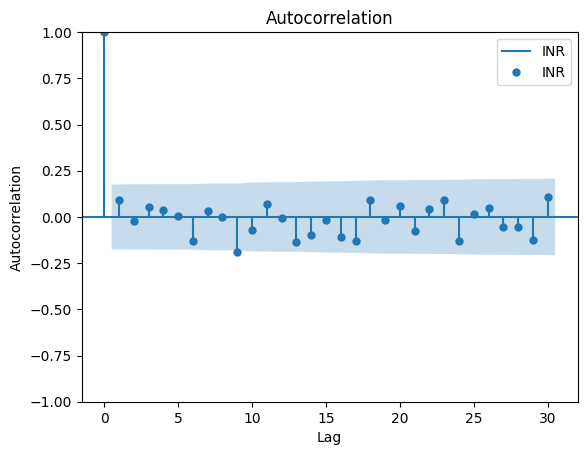

In [ ]:
plt.figure(figsize=(10, 6))
plot_acf(ind_df['Differenced_Data'], label = "INR", lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

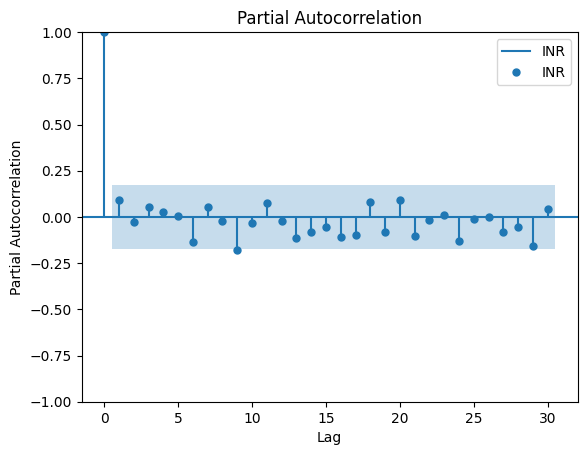

In [ ]:
plt.figure(figsize=(10, 6))
plot_pacf(ind_df['Differenced_Data'], label = "INR", lags=30)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.legend()
plt.show()

From the Auto-correlation and Partial Auto-correlation plots the parameters for Autoregressive `(p)` and Moving Average `(q)` models are determined as follows -



**INR**: `p = 9`, `q = 9`



#### Storing the final data sets on the local

In [ ]:
ind_df.to_csv('ind_finalm.csv')

In [ ]:
ind_df

,Exchange_rate,Differenced_Data
2014-02-01,62.1642,0.0585
2014-03-01,60.9476,-1.2166
2014-04-01,60.3464,-0.6012
2014-05-01,59.2843,-1.0621
2014-06-01,59.7367,0.4524
...,...,...
2024-02-01,82.9485,-0.1634
2024-03-01,83.0214,0.0729
2024-04-01,83.3968,0.3754
2024-05-01,83.3873,-0.0095


In [ ]:
# Splitting the dataset into train and test sets
split_index = int(0.9 * len(ind_df))
ind_train = ind_df['Differenced_Data'].iloc[:split_index]
ind_test = ind_df['Differenced_Data'].iloc[split_index:]

In [ ]:
ind_train

,Differenced_Data
2014-02-01,0.0585
2014-03-01,-1.2166
2014-04-01,-0.6012
2014-05-01,-1.0621
2014-06-01,0.4524
...,...
2023-01-01,-0.7328
2023-02-01,0.8585
2023-03-01,-0.3330
2023-04-01,-0.2980


In [ ]:
ind_test

,Differenced_Data
2023-06-01,-0.0725
2023-07-01,-0.0687
2023-08-01,0.6557
2023-09-01,0.2578
2023-10-01,0.1462
2023-11-01,0.0498
2023-12-01,-0.0120
2024-01-01,-0.1421
2024-02-01,-0.1634
2024-03-01,0.0729


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
start = len(ind_train)
end = len(ind_train) + len(ind_test) - 1

# Predicting the test values
ind_model = ARIMA(ind_train, order=(9,0,9))
ind_model_fit = ind_model.fit()
ind_pred = ind_model_fit.predict(start, end)
print(ind_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2023-06-01   -0.129899
2023-07-01   -0.702195
2023-08-01    0.142004
2023-09-01   -0.196783
2023-10-01   -0.198312
2023-11-01   -0.623347
2023-12-01   -0.217244
2024-01-01    0.557092
2024-02-01   -0.333235
2024-03-01    0.024530
2024-04-01    0.374295
2024-05-01    0.028893
2024-06-01    0.020623
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

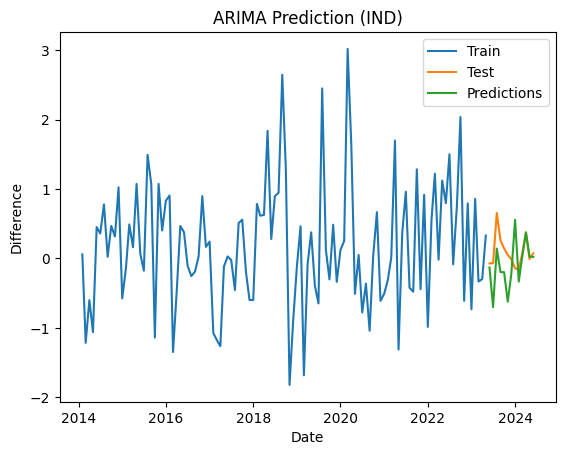

In [ ]:
ind_pred_df = pd.DataFrame(ind_pred)
ind_pred_df.index = ind_pred_df.index.astype(str)
plt.plot(ind_train[:split_index], label='Train')
plt.plot(ind_test, label='Test')
plt.plot(ind_pred, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('ARIMA Prediction (IND)')
plt.legend()
plt.show()

In [ ]:
mae_ind = mean_absolute_error(ind_test, ind_pred_df)
mse_ind = mean_squared_error(ind_test, ind_pred_df)
rmse_ind = np.sqrt(mean_squared_error(ind_test, ind_pred_df))
ind_perf = {'Currency':'Indian Rupees','MAE': mae_ind, 'MSE': mse_ind,
'RMSE': rmse_ind}
ind_perf = pd.DataFrame([ind_perf])
ind_perf

,Currency,MAE,MSE,RMSE
0,Indian Rupees,0.299311,0.154871,0.393536


Interpretation
From Plot: We observe that the model captures the trend very well, however, it looks like there is a downward shift in the predicted results.

From Performance Metrics: The error values are small (RMSE < 1), indicating that the model captured the trend in the dataset and is reliable.

## ARIMA

In [ ]:
forecast_index = pd.date_range(start = '2024-06-01', periods =10, freq = 'MS')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


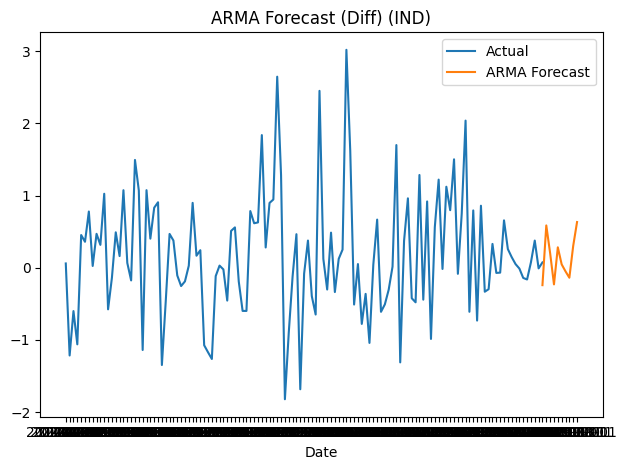

In [ ]:
ind = ARIMA(ind_df['Differenced_Data'], order = (9,0,9))
ind_model = ind.fit()
ind_forecast = ind_model.forecast(steps=10)
ind_forecast.index = forecast_index.astype(str)
plt.plot(ind_df['Differenced_Data'].index.astype(str),ind_df['Differenced_Data'][:], label='Actual')
plt.plot(ind_forecast.index,ind_forecast, label='ARMA Forecast')
plt.title('ARMA Forecast (Diff) (IND)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
ind_forecast_rates = ind_df['Exchange_rate'].iloc[-1] + ind_forecast.cumsum()
ind_forecasts = pd.concat([ind_df['Exchange_rate'], ind_forecast_rates], axis = 0)
ind_forecasts.to_csv('ind_arima_forecasts.csv')

In [ ]:
ind_forecasts

,0
2014-02-01 00:00:00,62.164200
2014-03-01 00:00:00,60.947600
2014-04-01 00:00:00,60.346400
2014-05-01 00:00:00,59.284300
2014-06-01 00:00:00,59.736700
...,...
2024-11-01,84.099888
2024-12-01,84.048900
2025-01-01,83.909874
2025-02-01,84.211670


Interpretation:
The forecasting shows that the USD currency value tends to remain steady as compared to INR over the next 10 months from June 2024.

However, there are continuous ups and downs in the value maintaining a constant mean for the forecasted 10 months

#SARIMA Modeling & Forecasting

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.2 MB/s eta 0:00:00


Determining the Seasonal Orders

In [ ]:
ind_params = auto_arima(ind_train,  start_p = 1,max_p = 10, start_q = 1, max_q = 10,seasonal=True, m=12, suppress_warnings=True, d=None,D=1, trace=True, error_action='ignore', stepwise=True)
print(ind_params.order)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.33 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=334.828, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=319.022, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=332.983, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=334.977, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=312.587, Time=1.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.09 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=311.512, Time=2.18 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=317.922, Time=1.14 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=312.525, Time=1.67 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=314.654, Time=

Training SARIMA model and Forecasting

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
ind_sarima = SARIMAX(ind_train, order = (9,0,9), seasonal_order = (2,1,0,12),enforce_stationarity=False, enforce_invertibility=False)
ind_sarima_fit = ind_sarima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


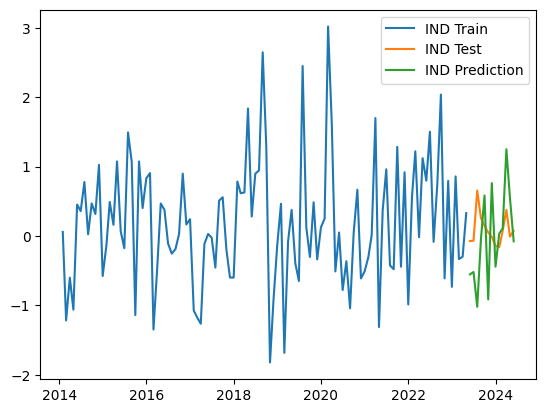

In [ ]:
ind_predict_sarima = ind_sarima_fit.predict(start, end).rename('SARIMA Ind Prediction')
ind_predict_sarima_df = pd.DataFrame(ind_predict_sarima)
ind_predict_sarima_df.index = ind_predict_sarima_df.index.astype(str)
plt.plot(ind_train[:split_index], label = 'IND Train')
plt.plot(ind_test, label = 'IND Test')
plt.plot(pd.to_datetime(ind_predict_sarima_df.index), ind_predict_sarima_df['SARIMA Ind Prediction'], label = 'IND Prediction')
plt.legend()
plt.show()

In [ ]:
mae_ind_sarima = mean_absolute_error(ind_test, ind_predict_sarima_df)
mse_ind_sarima = mean_squared_error(ind_test, ind_predict_sarima_df)
rmse_ind_sarima = np.sqrt(mean_squared_error(ind_test, ind_predict_sarima_df))
ind_perf_sarima = {'Currency':'Indian Rupees','MAE': mae_ind_sarima, 'MSE': mse_ind_sarima,
'RMSE': rmse_ind_sarima}
ind_perf_sarima = pd.DataFrame([ind_perf_sarima])
ind_perf_sarima

,Currency,MAE,MSE,RMSE
0,Indian Rupees,0.554138,0.48344,0.695298


Interpretation:

From Performance Metrics: The model has significant errors implying that the prediction is prone to errors.

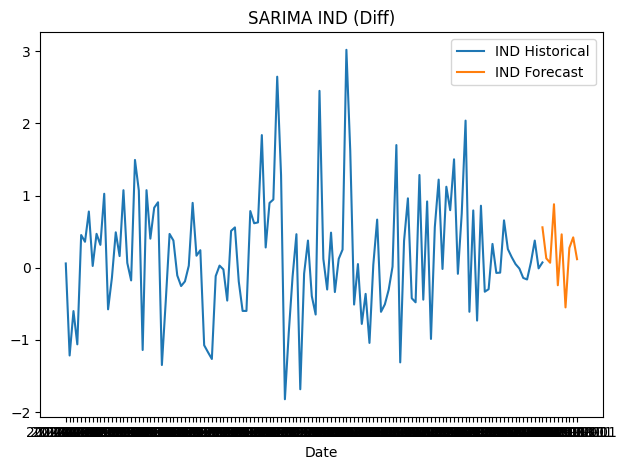

In [ ]:
ind_sarima = SARIMAX(ind_df['Differenced_Data'], order = (1,0,1), seasonal_order = (2,1,0,12),enforce_stationarity=False, enforce_invertibility=False)
ind_sarima_fit = ind_sarima.fit()
ind_forecast_sarima = ind_sarima_fit.forecast(steps = 10)
ind_forecast_sarima_df = pd.DataFrame(ind_forecast_sarima)
ind_forecast_sarima.index = forecast_index.astype(str)
plt.title('SARIMA IND (Diff)')
plt.plot(ind_df['Differenced_Data'].index.astype(str), ind_df['Differenced_Data'], label = 'IND Historical')
plt.plot(ind_forecast_sarima, label = 'IND Forecast')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
ind_forecast_rates_sarima = ind_df['Exchange_rate'].iloc[-1] + ind_forecast_sarima.cumsum()
ind_forecasts2 = pd.concat([ind_df['Exchange_rate'], ind_forecast_rates_sarima], axis = 0)
ind_forecasts2.to_csv('ind_sarima_forecasts.csv')

In [ ]:
ind_forecasts2

,0
2014-02-01 00:00:00,62.164200
2014-03-01 00:00:00,60.947600
2014-04-01 00:00:00,60.346400
2014-05-01 00:00:00,59.284300
2014-06-01 00:00:00,59.736700
...,...
2024-11-01,85.314198
2024-12-01,84.763803
2025-01-01,85.037679
2025-02-01,85.457707


In [ ]:
ind_forecast_rates_sarima

,predicted_mean
2024-06-01,84.019200
2024-07-01,84.148462
2024-08-01,84.216926
2024-09-01,85.095955
2024-10-01,84.852324
2024-11-01,85.314198
2024-12-01,84.763803
2025-01-01,85.037679
2025-02-01,85.457707
2025-03-01,85.575389


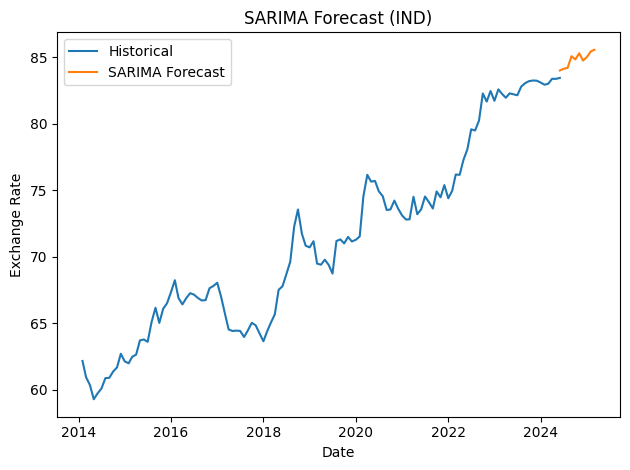

In [ ]:
import matplotlib.dates as mdates
ind_forecast_rates_sarima.index = pd.to_datetime(ind_forecast_rates_sarima.index)
plt.plot(ind_df['Exchange_rate'][:], label='Historical')
plt.plot(ind_forecast_rates_sarima.index, ind_forecast_rates_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast (IND)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

Interpretation
USD/INR ratio will experience a steep rise from June 2024 to March 2025 with March 2025 having the greatest monetary value for USD against INR. The value is USD will be ascending throughout the period.

Summary

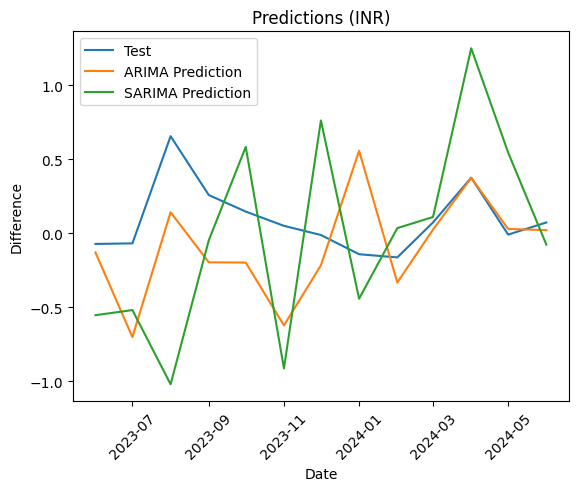

In [ ]:
ind_pred_df.index = pd.to_datetime(ind_pred_df.index)
ind_predict_sarima_df.index = pd.to_datetime(ind_predict_sarima_df.index)
plt.plot(ind_test, label='Test')
plt.plot(ind_pred_df, label='ARIMA Prediction')
plt.plot(ind_predict_sarima_df, label = 'SARIMA Prediction')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('Predictions (INR)')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

ARIMA performs slightly better based on lower MAE, MSE, and RMSE.

#LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from matplotlib import pyplot as plt


In [ ]:
# Load your data (replace with your actual file path)
df = pd.read_csv('/content/indm.csv')
df

,Unnamed: 0,0
0,1973-01-01,8.0041
1,1973-02-01,7.7538
2,1973-03-01,7.5465
3,1973-04-01,7.5462
4,1973-05-01,7.4927
...,...,...
615,2024-04-01,83.3968
616,2024-05-01,83.3873
617,2024-06-01,83.4600
618,2024-07-01,83.5895


In [ ]:
# Assuming the first column (index 0) contains the dates
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='%Y-%m-%d')

# Set the first column as the index
df.set_index(df.columns[0], inplace=True)

# Print the updated DataFrame to check
df

,0
Unnamed: 0,
1973-01-01,8.0041
1973-02-01,7.7538
1973-03-01,7.5465
1973-04-01,7.5462
1973-05-01,7.4927
...,...
2024-04-01,83.3968
2024-05-01,83.3873
2024-06-01,83.4600


In [ ]:
df = pd.DataFrame({'Exchange_rate': ind_monthly})
df

,Exchange_rate
1973-01-01,8.0041
1973-02-01,7.7538
1973-03-01,7.5465
1973-04-01,7.5462
1973-05-01,7.4927
...,...
2024-04-01,83.3968
2024-05-01,83.3873
2024-06-01,83.4600
2024-07-01,83.5895


In [ ]:
data = df['Exchange_rate']

In [ ]:
data

,Exchange_rate
1973-01-01,8.0041
1973-02-01,7.7538
1973-03-01,7.5465
1973-04-01,7.5462
1973-05-01,7.4927
...,...
2024-04-01,83.3968
2024-05-01,83.3873
2024-06-01,83.4600
2024-07-01,83.5895


In [ ]:
data = np.array(data).reshape(-1,1)

The data is reshaped into a 2D array, which is required for scaling and further processing by LSTM. This ensures that the data can be handled in the LSTM model, which expects 2D input for sequences.

In [ ]:
data

array([[ 8.0041],
       [ 7.7538],
       [ 7.5465],
       [ 7.5462],
       [ 7.4927],
       [ 7.2719],
       [ 7.351 ],
       [ 7.5643],
       [ 7.7   ],
       [ 7.7271],
       [ 7.834 ],
       [ 8.11  ],
       [ 8.4377],
       [ 8.2444],
       [ 8.0567],
       [ 7.8655],
       [ 7.7855],
       [ 7.849 ],
       [ 7.8345],
       [ 7.9841],
       [ 8.121 ],
       [ 8.0505],
       [ 8.0644],
       [ 8.0952],
       [ 8.13  ],
       [ 7.9717],
       [ 7.75  ],
       [ 7.8841],
       [ 8.07  ],
       [ 8.1914],
       [ 8.4895],
       [ 8.7895],
       [ 8.8648],
       [ 8.8945],
       [ 8.8994],
       [ 8.9827],
       [ 8.9471],
       [ 8.9389],
       [ 8.9648],
       [ 8.9918],
       [ 9.0265],
       [ 9.1109],
       [ 8.9233],
       [ 8.9755],
       [ 9.0614],
       [ 8.896 ],
       [ 8.9658],
       [ 8.8535],
       [ 8.9052],
       [ 8.8626],
       [ 8.8417],
       [ 8.8429],
       [ 8.8338],
       [ 8.8605],
       [ 8.8163],
       [ 8

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
data = scaler.fit_transform(data)

The MinMaxScaler is applied to scale the data between 0 and 1. This is necessary for LSTM, as neural networks often perform better when the input data is normalized.

In [ ]:
data

array([[0.00955705],
       [0.00629001],
       [0.00358422],
       [0.0035803 ],
       [0.00288199],
       [0.        ],
       [0.00103245],
       [0.00381655],
       [0.00558778],
       [0.0059415 ],
       [0.00733682],
       [0.01093931],
       [0.01521662],
       [0.01269357],
       [0.01024361],
       [0.00774797],
       [0.00670377],
       [0.00753261],
       [0.00734334],
       [0.009296  ],
       [0.01108289],
       [0.01016269],
       [0.01034412],
       [0.01074613],
       [0.01120036],
       [0.00913415],
       [0.00624041],
       [0.00799075],
       [0.01041721],
       [0.01200179],
       [0.01589274],
       [0.01980849],
       [0.02079135],
       [0.02117901],
       [0.02124296],
       [0.02233024],
       [0.02186557],
       [0.02175854],
       [0.0220966 ],
       [0.02244902],
       [0.02290194],
       [0.02400357],
       [0.02155492],
       [0.02223626],
       [0.02335747],
       [0.02119859],
       [0.02210965],
       [0.020

In [ ]:
split_percent = 0.9
split = int(split_percent * len(X))
#Training and test sets
train = data[:split]
test = data[split:]

print(train.shape)
print(test.shape)

(547, 1)
(73, 1)


The dataset is split into training and testing sets. In this case, 90% of the data is used for training, and 10% for testing.

In [ ]:
def get_data(data, look_back):
  datax, datay = [],[]
  for i in range(len(data)-look_back-1):
    datax.append(data[i:(i+look_back),0])
    datay.append(data[i+look_back,0])
  return np.array(datax) , np.array(datay)

In [ ]:
look_back = 1

x_train , y_train = get_data(train, look_back)
print(x_train.shape)
print(y_train.shape)

(545, 1)
(545,)


In [ ]:
x_test , y_test = get_data(test,look_back)
print(x_test.shape)
print(y_test.shape)

(71, 1)
(71,)


A helper function `get_data()` is created to prepare the data for LSTM. It converts the time-series data into a sequence format that LSTM can process. `look_back` is set to 1, meaning the model will use the previous value to predict the next value. The data is split into input (`x_train` and `x_test`) and output (`y_train` and `y_test`) arrays.

In [ ]:
#Processing train and test sets for LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

The training and testing sets are reshaped to fit the 3D input required by the LSTM network.

In [ ]:
print(x_train.shape)
print(x_test.shape)

(545, 1, 1)
(71, 1, 1)


In [ ]:
#Defining the LSTM model
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [ ]:
n_features=x_train.shape[1]
model=Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, n_features)))

# Second LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=True))

# Third LSTM layer
model.add(LSTM(50, activation='relu'))

# Output layer (Dense layer)
model.add(Dense(n_features))


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 50)               │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,251 (356.45 KB)

 Trainable params: 91,251 (356.45 KB)

 Non-trainable params: 0 (0.00 B)

A sequential model is built using 3 LSTM layers with 100, 50, and 50 units respectively. Each LSTM layer uses the `ReLU` activation function. The final output layer is a dense layer with one unit, predicting a single value (the exchange rate).

In [ ]:
#Compiling
model.compile(optimizer='adam', loss = 'mse')

In [ ]:
#Training
model.fit(x_train,y_train, epochs = 20, batch_size=1)

Epoch 1/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0748
Epoch 2/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0035
Epoch 3/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0010
Epoch 4/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4578e-04
Epoch 5/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8062e-04
Epoch 6/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7303e-04
Epoch 7/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4844e-04
Epoch 8/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6151e-04
Epoch 9/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6181e-04
Epoch 10/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0543e-04
Epoch 11/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6816e-04
Epoch 12/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3364e-04
Epoch 13/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4308e-04
Epoch 14/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2508e-04
Epoch 15/20
5

In [ ]:
#Prediction using the trained model
scaler.scale_

array([0.01305251])

In [ ]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print(y_pred[:10])

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step
[[69.399055]
 [72.263   ]
 [73.683655]
 [71.67152 ]
 [70.688446]
 [70.555504]
 [71.05747 ]
 [69.24761 ]
 [69.15965 ]
 [69.560135]]


After training, the model is used to predict the test data. The predicted values are then transformed back to their original scale using the inverse of the MinMaxScaler.

In [ ]:
#Processing test shape
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)
print(y_test[:10])

[[72.2779]
 [73.5609]
 [71.738 ]
 [70.8331]
 [70.71  ]
 [71.1739]
 [69.4895]
 [69.4068]
 [69.7827]
 [69.388 ]]


The actual y_test values are also transformed back to their original scale for comparison with the predictions.

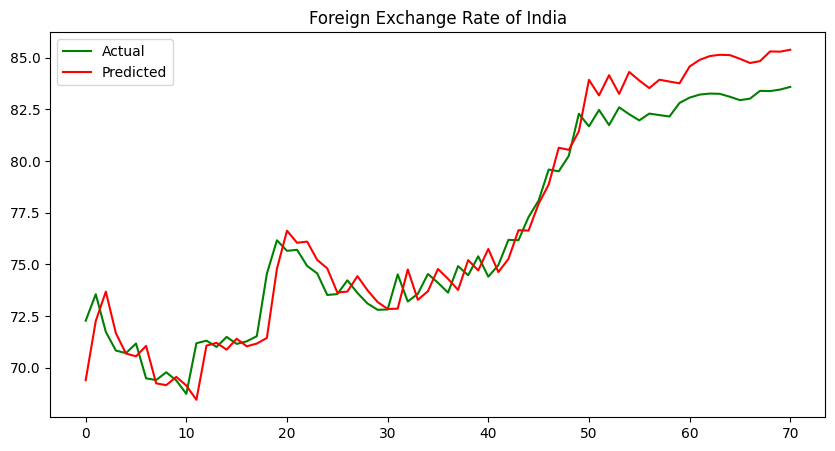

In [ ]:
#Visualizing the results
plt.figure(figsize=(10,5))
plt.title('Foreign Exchange Rate of India')
plt.plot(y_test , label = 'Actual', color = 'g')
plt.plot(y_pred , label = 'Predicted', color = 'r')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

1.7210108532623594

In [ ]:
# Calculate MSE, MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# RMSE is the square root of MSE
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 1.7210108532623594
Mean Absolute Error (MAE): 1.0828727846817223
Root Mean Squared Error (RMSE): 1.311873032447256


**MSE** :  The relatively high MSE suggests that there are some larger deviations between the predicted and actual values in the LSTM model's predictions.

**MAE** : This indicates that on average, the LSTM's forecast error is moderate.

**RMSE** : The LSTM model's predictions are about 1.31 units away from the actual values, which reflects moderate predictive performance.

The errors, on average, indicate that the model's predictions deviate by about 1.08 to 1.31 units from the actual exchange rates. While LSTM is capable of capturing complex time-series patterns, these results suggest that it may not have fully captured the underlying trend of the data

#Exponential Smoothing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

The seasonal period is set to 12, indicating the assumption that the data exhibits yearly seasonality (12 months).


The Exponential Smoothing model is fit using both an additive trend and additive seasonality. This model assumes that both the level and the seasonality components of the time series grow or decay linearly over time.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


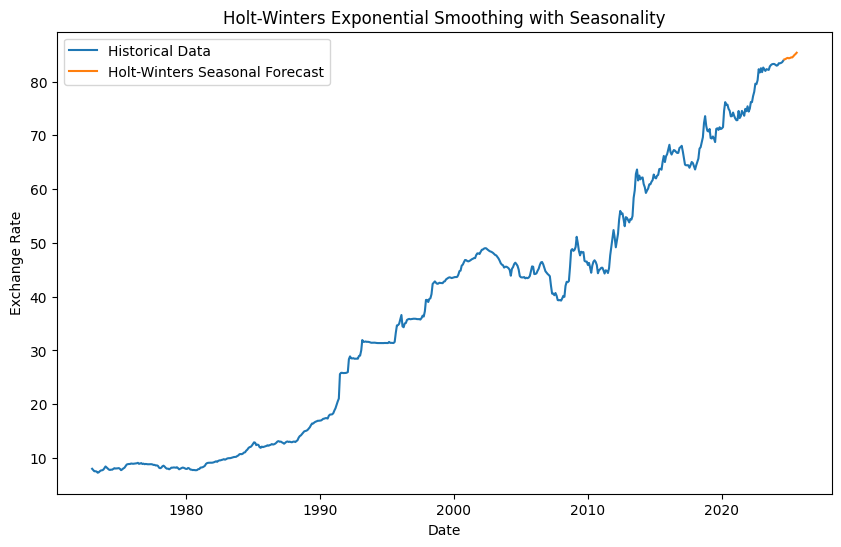

In [ ]:
seasonal_periods = 12

# fiting the Holt-Winters model
model = ExponentialSmoothing(df['Exchange_rate'], trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit()

# forecasting the next 12 periods
forecast = model.forecast(12)

plt.figure(figsize=(10,6))
plt.plot(df['Exchange_rate'], label='Historical Data')
plt.plot(forecast, label='Holt-Winters Seasonal Forecast')
plt.title('Holt-Winters Exponential Smoothing with Seasonality')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df['Exchange_rate'][-12:], forecast)
mse = mean_squared_error(df['Exchange_rate'][-12:], forecast)
rmse = mse ** 0.5

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 1.259804308958369
MSE: 1.6253170094454656
RMSE: 1.2748792136690699


**MAE** : The forecasted exchange rate is off by about 1.26 units . This error indicates a moderate deviation from the true values.

**MSE** : It suggests that there are some larger deviations between the predicted and actual values, which are penalized more due to the squaring process.

**RMSE** : On average, the model's forecasted values are approximately 1.27 units away from the actual values. This indicates that the model's predictions have moderate error overall.

## Comparing the four models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

#function to calculate RMSE, MSE, and MAE
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

results = {}

#ARIMA model
mse_arima, rmse_arima, mae_arima = calculate_metrics(ind_test, ind_pred_df)
results['ARIMA'] = [mse_arima, rmse_arima, mae_arima]

#SARIMA model
mse_sarima, rmse_sarima, mae_sarima = calculate_metrics(ind_test, ind_predict_sarima_df)
results['SARIMA'] = [mse_sarima, rmse_sarima, mae_sarima]

#LSTM model
mse_lstm, rmse_lstm, mae_lstm = calculate_metrics(y_test, y_pred)
results['LSTM'] = [mse_lstm, rmse_lstm, mae_lstm]

#Exponential Smoothing model
mse_exp, rmse_exp, mae_exp = calculate_metrics(df['Exchange_rate'][-12:], forecast)
results['Exponential Smoothing'] = [mse_exp, rmse_exp, mae_exp]

# dataFrame to display the results
metrics_df = pd.DataFrame(results, index=['MSE', 'RMSE', 'MAE'])
metrics_df


,ARIMA,SARIMA,LSTM,Exponential Smoothing
MSE,0.154871,0.483440,1.721011,1.625317
RMSE,0.393536,0.695298,1.311873,1.274879
MAE,0.299311,0.554138,1.082873,1.259804


ARIMA performed the best across all metrics, indicating that it provides the most accurate predictions for this dataset. It captures the trend well with minimal error.

SARIMA also performs well, but not as accurately as ARIMA. It has a higher error rate, indicating that it may not capture seasonal effects as effectively for this dataset.

 LSTM has the highest error rates in all metrics. This suggests that while LSTM can model complex relationships, it may not perform as well on this specific dataset compared to traditional time-series models like ARIMA and SARIMA.

 Exponential Smoothing shows higher errors compared to ARIMA and SARIMA but slightly better than LSTM. It may be a reasonable choice for simple seasonal data, but it does not outperform ARIMA or SARIMA here.

**Therefore ARIMA would be the preferred model for forecasting in this case.**